# Project Milestone P2 — StatSquad3 — How does the sentiment of Wikispeedia articles affect player game paths?
## I. Exploring sentiment annotation methods

- In this project, we aim to describe and analyze data based on a sentiment associated to each Wikispeedia page. To do so, we believe that our analyses will strongly depend on the sentiment annotation method. Therefore, in this first part, we extensively explore the different methods of sentiment annotation. 
- By "sentiment annotation", we mean that each article will be given a score for its content. A sentiment score $s\in[-1,1]$ where $s=1$ (respectively, $s=0$, $s=-1$) means an article is associated to a positive (respectively, neutral, negative) sentiment.
#### We start off by exploring different method for sentiment annotation of the Wikispeedia articles. Namely, we explore five different methods: 
1. Using sentiment lexicons to infer sentiment frequencies: using a positive and negative score for each word in a lexicon, the individual token scores are summed for each article.
2. pattern package: Pattern is a python package that leverages a sentiment dictionary to score each word on polarity and subjectivity. Polarity (emotional direction (positive or negative)) and subjectivity (strength of emotion) are particularly interesting in the case of wikipedia.
3. [Vader](https://vadersentiment.readthedocs.io/en/latest/index.html) (Valence Aware Dictionary and sEntiment Reasoner): VADER is a lexicon and rule-based sentiment analysis tool specifically designed for social media content. It is sensitive to both the polarity (positive/negative) and intensity (strength) of emotions. This method uses a sentiment lexicon which is a list of lexical features, like words, that are generally labeled with their sentiment intensity. It is known for its effectiveness in handling social media texts and other domains where expressions are less formal and more emotionally varied.
4. [LIWC](https://www.liwc.app/dictionaries) (Linguistic Inquiry and Word Count): LIWC counts words in psychologically meaningful categories. This method is particularly adept at showing attentional focus, emotionality, social relationships, thinking styles, and individual differences in texts.
5. Large language model ([Roberta for sentiment analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)) (A Robustly Optimised BERT Pre-training Approach): RoBERTa is a large language model (Meta Research), which is trained on a vast corpus of data for self-supervised natural language processing. It performs binary sentiment analysis, categorising text as either positive or negative. RoBERTa has been fine-tuned on millions of tweets, making it suitable to detect sentiment.

In order for us to compare these different methods, we manually put together a small validation set of articles that are considered very positive, very negative, or neutral. We show it below:

In [1]:
import pandas as pd

validation = pd.read_csv("../validation.txt", sep="\t", header=None, names=["article", "sentiment"])
validation = validation.set_index("article")
validation.head()

,sentiment
article,
1755_Lisbon_earthquake,-1
1896_Summer_Olympics,1
1997_Pacific_hurricane_season,-1
Actinium,0
Barracuda,-1


In the next sections, we try to reproduce the sign of the sentiment rather than the score it

### 1. Lexicons

#### Method: we use a sentiment lexicon: each word in the lexicon has a positive and negative score both in the interval $[0,1]$. For each article, we infer the sentiment score by computing $\text{positive-score}-\text{negative-score}$

In [2]:
from sentiment_analysis_1 import *

In [3]:
articles = load_titles()
print(len(articles), "articles found")

4604 articles found


In [4]:
content = load_html(articles)

Load and parse lexicons

In [5]:
sentiment_lexicon_path = "../sentiwordnet/SentiWordNet_3.0.0.txt"
df = pd.read_csv(sentiment_lexicon_path, sep="\t", skiprows=25, skipfooter=1, engine="python")

def parse_synset_terms(row):
    words = row.split()
    words = [word.split('#')[0] for word in words]
    return words

df['SynsetTerms'] = df['SynsetTerms'].apply(parse_synset_terms)
df = df.explode('SynsetTerms').reset_index(drop=True)
df[["PosScore", "NegScore", "SynsetTerms"]].head()

,PosScore,NegScore,SynsetTerms
0,0.125,0.00,able
1,0.000,0.75,unable
2,0.000,0.00,dorsal
3,0.000,0.00,abaxial
4,0.000,0.00,ventral


Compute sentiment score for lexicon

In [6]:
sentiment = dict(zip(df.SynsetTerms, round(df.PosScore - df.NegScore,5)))

Infer sentiment score for validation data

In [7]:
def model(articles_content, lexicon):
    """
    Infer the sentiment prediction for articles on their content, according to lexicon of sentiments
    Args:
        articles_content: dict(), dictionary of (article-title: article-content) pairs
        lexicon: dict(), dictionary of (word: sentiment) pairs, with sentiment a sentiment score
    Returns:
        dict(), dictionary of (article-title: average-score) pairs
    """
    article_scores = {}

    for title, content in articles_content.items():
        words = content.split()
        word_scores = [lexicon[word] for word in words if word in lexicon]
        average_score = sum(word_scores) / len(word_scores) if len(word_scores) > 0 else None
        article_scores[title] = average_score

    return article_scores

In [8]:
validation_content = dict(zip(list(validation.index), [None]*len(validation)))
for k in validation_content.keys():
    validation_content[k] = content[k]

In [9]:
scores = model(validation_content, sentiment)

In [10]:
validation["prediction"] = scores.values()

In [11]:
validation.head()

,sentiment,prediction
article,,
1755_Lisbon_earthquake,-1,-0.050156
1896_Summer_Olympics,1,-0.006281
1997_Pacific_hurricane_season,-1,-0.037893
Actinium,0,-0.005826
Barracuda,-1,-0.002747


In [12]:
print("Number of correct prediction signs:")
print(sum((validation["sentiment"] * validation["prediction"]) > 0), "/", len(validation))

Number of correct prediction signs:
15 / 35


We also tried correcting the predictions by a bias (by adding a weighted average of the predictions), but we cannot do better than that. The model is therefore worse than a random classifier.

### 2. Pattern

In [3]:
file_names = ['1755_Lisbon_earthquake','1896_Summer_Olympics','1997_Pacific_hurricane_season','Actinium','Barracuda','Basketball','Bath_School_disaster','Chicago','Chocolate','Diamond','Dice','Drinking_water','Duchenne_muscular_dystrophy','Geography_of_Ireland','Giraffe','Gunpowder','Osama_bin_Laden','Palm_oil','Peace','Pellagra','Phishing','Plant','Plato','Pneumonia','Poison_gas_in_World_War_I','Politics','Pollution','Red_Kite','Rice','Rio_de_Janeiro','Romeo_and_Juliet','Rugby_World_Cup','Rwandan_Genocide','Santa_Claus','Scooby-Doo']
len(file_names)

35

#### Model Description
Pattern is a multipurpose library that is capable of handling NLP operations, data mining, machine learning etc. It also contains sentiment analysis functionality which is suitable for our task.
The `sentiment` function under `pattern.text.en` module is used to calculate the sentiment of a given text, it takes a sentence as input which can also be a string, Synset, word or document, and returns a (polarity, subjectivity)-tuple with polarity between -1.0 and +1.0 and subjectivity between 0.0 and 1.0. polarity describes the emotional leaning of the text, while subjectivity describes the strength of such emotion.

In our usage the input is a string of the entire article loaded from the Wikispeedia dataset, In this case, it first tokenizes the text into words(punctuation, space and abbreviations are handled at this stage), then it Lowercases each word because sentiment analysis is case insensitive. Next it calculates the sentiment of each word by consulting the predefined sentiment [dictionary](https://github.com/clips/pattern/blob/master/pattern/text/en/en-sentiment.xml)(modifiers and negations are also considered at this time). Finally it returns the average of all the words as the sentiment of the text.

Although similar to the above method, pattern is certainly a more complete method and it includes the subjectivity measure which is especially in the case of Wikipedia, as the articles are, after all, written by humans. More details can be found in the [official documentation](https://digiasset.org/html/pattern.html) and [repository](https://digiasset.org/html/pattern.html). 

#### Method & Results

In [2]:
from pattern.text.en import sentiment

In [4]:
for file_name in file_names:
    with open('../data/plaintext_articles/'+file_name+'.txt', 'r', encoding='utf-8') as file:
        data = file.read()
        polarity, subjectivity = sentiment(data)
        print(f"{file_name}: {polarity}")

1755_Lisbon_earthquake: 0.0816923282902664
1896_Summer_Olympics: 0.11173071331653418
1997_Pacific_hurricane_season: 0.051366249491249474
Actinium: 0.03542682926829269
Barracuda: 0.1132213321465658
Basketball: 0.08600218021995364
Bath_School_disaster: 0.010679336219336222
Chicago: 0.10564842500695483
Chocolate: 0.07674311830989919
Diamond: 0.12359236785162714
Dice: -0.0001423413188119043
Drinking_water: 0.12155415214866433
Duchenne_muscular_dystrophy: 0.051342562953478464
Geography_of_Ireland: 0.06101678376268537
Giraffe: 0.04892030793508625
Gunpowder: 0.01667841269841271
Osama_bin_Laden: 0.04482218734525007
Palm_oil: 0.10377811870669014
Peace: 0.07109719189365207
Pellagra: 0.013132859204287773
Phishing: 0.03130031080031078
Plant: 0.09383068133068131
Plato: 0.16051446416831025
Pneumonia: 0.05341062158293232
Poison_gas_in_World_War_I: 0.08464027042373903
Politics: 0.10395405509821987
Pollution: 0.08715013543960917
Red_Kite: 0.035212025919573085
Rice: 0.08478642004761416
Rio_de_Janeiro: 0

#### Discussion
The performance of this model is generally not good compared to other models we tested, the possible reason could be that it uses a fixed sentiment dictionary which may contain bias between different domains. It's observed that the model tends to give a very small value between [0,0.1] despite the articles, a reason could be that Wikipedia articles are designed to be neutral and objective, It generally looks at problems dialectically and rarely produces strong emotions. However, in the range of this project, we care more about the sentiment level of the article (the word itself) rather than the way it is written, the model considers all the words on the page evenly and thus may produce results that are not what we expect.

This is not the optimal model for our task, a ML-based approach is generally more flexible and powerful in this case.

### 3. Vader

#### Model description
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis method attuned expressions from social media. This model classies the text into positive, neutral, and negative parts, then by leveraging lexicon and grammatical rules, from valence scores compute the 'compound score' which is normalized weighted composite score of the sentiment of the text.

Utilizing NLTK, VADER takes into condsideration the text nuances, informal phrases, and even non-English text sentences.

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm
from sentiment_analysis_3 import *

#### Load articles' titles and content

In [18]:
articles = load_titles_3()
content = load_html_3(articles)

#### Analysing the compound score

In [19]:
scores = []
analyzer = SentimentIntensityAnalyzer()
for article_content in tqdm(content.iloc):
    vs = analyzer.polarity_scores(article_content.content)
    scores.append(vs['compound'])

0it [00:00, ?it/s]

#### Resulted scores

In [20]:
content['score'] = scores
content.drop(columns='content')

,title,score
0,1755_Lisbon_earthquake,-0.9970
1,1896_Summer_Olympics,0.9999
2,1997_Pacific_hurricane_season,-0.9998
3,Actinium,-0.8792
4,Barracuda,0.9944
5,Basketball,0.9999
6,Bath_School_disaster,-0.9998
7,Chicago,0.9999
8,Chocolate,0.9996
9,Diamond,1.0000


#### Discussion 
As can be inferred from the prediction, the model is good at correctly splitting the articles into two separate clusters, with a quite impressive squared error of 0.2. However, the obtained scores are quite extreme, making it impractical to infer the intensity of the negative or positive sense of each article. This could be attributed to the prevalence of neutral words, causing smaller differences between negative and positive counterparts.

### 4. LIWC
#### Model Description

Linguistic Inquiry and Word Count (LIWC) is a sentiment analysis model based on over 100 dictionaries. In each of these dictionaries, words are assiociated with psychological state, as positive, negative, but also moralization and cognitive process for example. LIWC analyzes each word and compare it with the dictionnaries, to output the percentage of word that belong to each category. In our case, only the 'positive tone' and 'negative tone' category are of interest.

#### Method & Results

The free LIWC demo version has a 5000 character limit, so the first step is to divide the text in several chunks that can be run through the demo.

Note: for clarity we leave the main pipelines in the notebook ```sentiment_analysis_4.ipynb```. Here we load the predictions directly.

In [36]:
preds = pd.read_csv('./tmp/finalscore.csv',header=None)

In [41]:
preds

,0
0,-0.324
1,0.792
2,-0.703
3,-0.856
4,0.223
5,0.356
6,-0.538
7,0.682
8,0.263
9,0.638


#### Comparison

The results are then compared to the expected results (manually evaluated). Both can be plotted on a graph to have a visualization of the accuracy of the model. The mean square error is then calculated.

The mean square error of the model on the validation articles is 0.381691


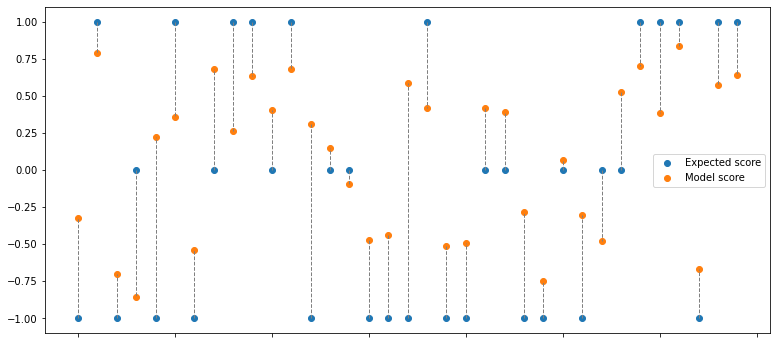

In [40]:
import matplotlib.pyplot as plt
import numpy as np

expected_score=np.array([-1,1,-1,0,-1,1,-1,0,1,1,0,1,-1,0,0,-1,-1,-1,1,-1,-1,0,0,-1,-1,0,-1,0,0,1,1,1,-1,1,1])
model_score=np.array(preds).reshape(-1)

errors=expected_score-model_score

x=np.arange(len(expected_score))

fig,ax=plt.subplots(1,figsize=(13,6))

ax.scatter(x,expected_score,label='Expected score')
ax.scatter(x,model_score,label='Model score')

for i in range(len(x)):
    ax.plot([x[i],x[i]],[expected_score[i],model_score[i]],color='gray',linestyle='--',linewidth=1)

ax.set_xticklabels([])
ax.legend()

mse=np.mean(np.square(errors))

print(f'The mean square error of the model on the validation articles is {mse}')

In conclusion: this model is already much better than the previous ones.

### 5. Roberta for sentiment analysis

For practical purposes, we do not run Roberta in this notebook. We have done it in a machine with sufficient memory to infer the predictions on the validation data, which we load and show below. The notebook used is ```sentiment_analysis_5.ipynb```.

In [42]:
preds = np.array([-0.75, 0.62, -0.71, -0.85, 0.42, 0.56, -0.81, 0.65, 0.42, 0.58, 0.57, 0.21, -0.62, -0.44, 0.36, -0.64, -0.8, 0.58, 0.53, -0.86, -1, 0.43, 0.43, -0.93, -0.94, 0.39, -0.82, -0.55, 0.49, 0.86, -0.53, 0.65, -0.96, 0.61, 0.58])

The mean square error of the model on the validation articles is 0.35532857142857144


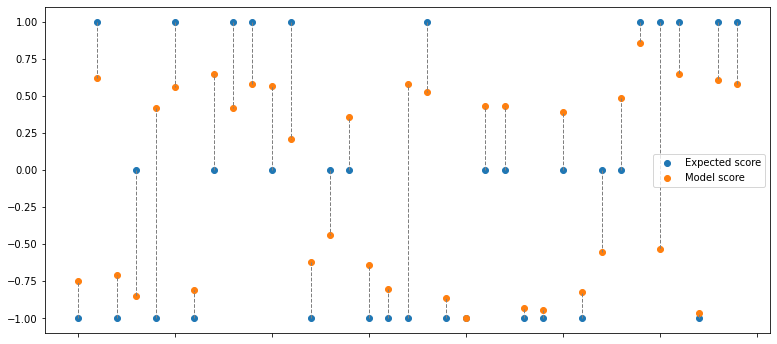

In [43]:
expected_score=np.array([-1,1,-1,0,-1,1,-1,0,1,1,0,1,-1,0,0,-1,-1,-1,1,-1,-1,0,0,-1,-1,0,-1,0,0,1,1,1,-1,1,1])
model_score=preds

errors=expected_score-model_score

x=np.arange(len(expected_score))

fig,ax=plt.subplots(1,figsize=(13,6))

ax.scatter(x,expected_score,label='Expected score')
ax.scatter(x,model_score,label='Model score')

for i in range(len(x)):
    ax.plot([x[i],x[i]],[expected_score[i],model_score[i]],color='gray',linestyle='--',linewidth=1)

ax.set_xticklabels([])
ax.legend()

mse=np.mean(np.square(errors))

print(f'The mean square error of the model on the validation articles is {mse}')

Visually, Roberta seems to be similar to the previous LIWC model. Indeed, the bars larger than 1 (the ones that "invert" the sentiment of the article) are equally present in this plot compared to the previous one. However, the MSE is slightly lower, so we should perhaps use this model as the inference for the sentiment.

# II. Some initial analyses and initial loading pipelines for player paths
In order to run this part, you need to download the `wikispeedia_paths-and-graph.tar.gz` and `wikispeedia_articles_plaintext.tar.gz` from [here](https://snap.stanford.edu/data/wikispeedia.html) , extract them and put them in the ```data``` folder which should be in the same folder as this project.
### 1. Load and reformat the data

In [5]:
import pandas as pd

Loading the data of finished path

In [7]:
file_path = '../data/paths_finished.tsv'
df_finished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
df_finished.columns = cols
df_finished['target'] = df_finished['path'].apply(lambda x: x.split(';')[-1])
df_finished['type'] = 'finished'
df_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,type
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African_slave_trade,finished
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African_slave_trade,finished
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African_slave_trade,finished
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,finished
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John_F._Kennedy,finished


Loading the data of unfinished path

file_path = '../data/paths_unfinished.tsv'
df_unfinished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']
df_unfinished.columns = cols
df_unfinished.head()

merge them together

In [10]:
df = pd.concat([df_finished, df_unfinished], axis=0)
df['start'] = df['path'].apply(lambda x: x.split(';')[0])
df.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,type,start
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African_slave_trade,finished,14th_century
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African_slave_trade,finished,14th_century
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African_slave_trade,finished,14th_century
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,finished,14th_century
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John_F._Kennedy,finished,14th_century


load the articles(nodes) and links between them(edges)

In [12]:
file_path = '../data/links.tsv'
df_links = pd.read_csv(file_path, sep='\t', header=None)
df_links.head()

,0,1
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


In [14]:
articles = pd.read_csv('../data/articles.tsv', sep='\t', header=None)

### 2. Some Statistics and visualizations

- basics

In [16]:
print('Number of games played: {}, with {:.2f}% finished rate'.format(len(df), len(df_finished)/len(df)*100))
print('Number of participated individuals: {}'.format(len(df['hashedIpAddress'].unique())))
used_articles = set([item for sublist in df['path'].apply(lambda x: x.split(';')) for item in sublist])
print('Number of articles: {}, {:.2f}% are covered in the game'.format(len(articles), len(used_articles)/len(articles)*100))
print('Number of edges: {}, with average degree {:.0f}'.format(len(df_links), len(df_links)/len(articles)))

Number of games played: 76193, with 67.35% finished rate
Number of participated individuals: 20868
Number of articles: 4604, 90.86% are covered in the game
Number of edges: 119882, with average degree 26


- Degree distribution analysis
Consider that every edge is bidirectional because the user can go back through the back button.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# calculate the degree of each article
articles.columns = ['article']
# left join to get the degree of each article
degree_out = df_links.groupby(0).count().reset_index()
degree_out.columns = ['article', 'degree_out']
degree_in = df_links.groupby(1).count().reset_index()
degree_in.columns = ['article', 'degree_in']
articles = articles.merge(degree_out, on='article', how='left').fillna(0).merge(degree_in, on='article', how='left').fillna(0)
articles['degree'] = articles['degree_out'] + articles['degree_in']
articles.describe()

,degree_out,degree_in,degree
count,4604.000000,4604.000000,4604.000000
mean,26.038662,26.038662,52.077324
std,24.201491,62.746827,78.551771
min,0.000000,0.000000,0.000000
25%,11.000000,2.000000,16.000000
50%,19.000000,8.000000,30.000000
75%,33.000000,25.000000,59.000000
max,294.000000,1551.000000,1845.000000


In [18]:
# print top 5 articles with highest degree
articles.sort_values('degree', ascending=False).head()

,article,degree_out,degree_in,degree
4297,United_States,294.0,1551.0,1845.0
4293,United_Kingdom,168.0,972.0,1140.0
1433,Europe,159.0,933.0,1092.0
1568,France,85.0,959.0,1044.0
1385,England,172.0,751.0,923.0


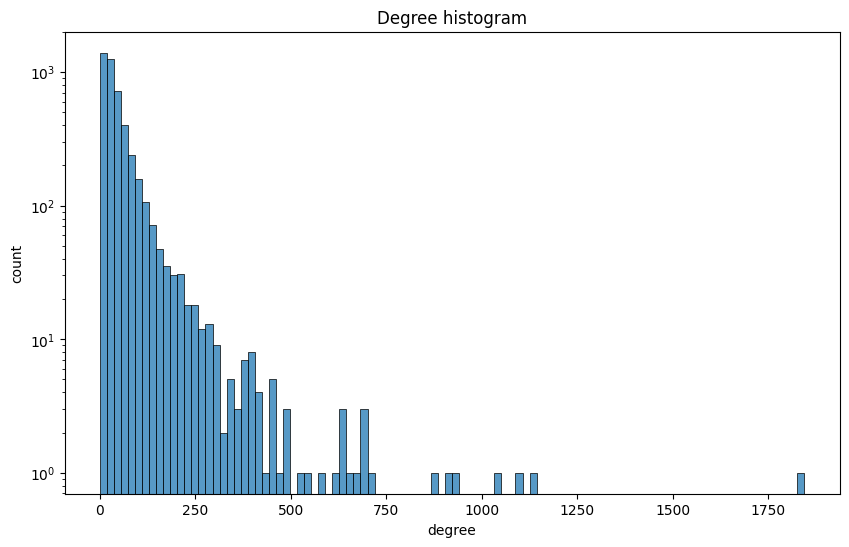

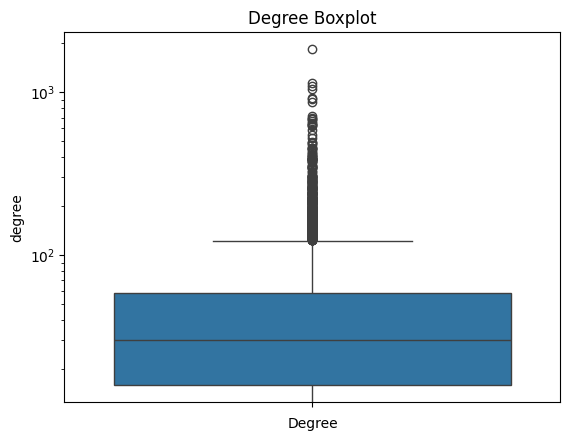

In [19]:
# plot the hist degree distribution with logy scale
plt.figure(figsize=(10, 6))
sns.histplot(articles['degree'], kde=False, bins=100)
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Degree histogram')
plt.show()

sns.boxplot(articles['degree'])
plt.xlabel('Degree')  
plt.title('Degree Boxplot') 
plt.yscale('log')
plt.show()

- path length distribution anlysis

In [20]:
df['path_length'] = df['path'].apply(lambda x: len(x.split(';')))
df['path_length'].describe()

count    76193.000000
mean         6.248251
std          5.115519
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max        435.000000
Name: path_length, dtype: float64

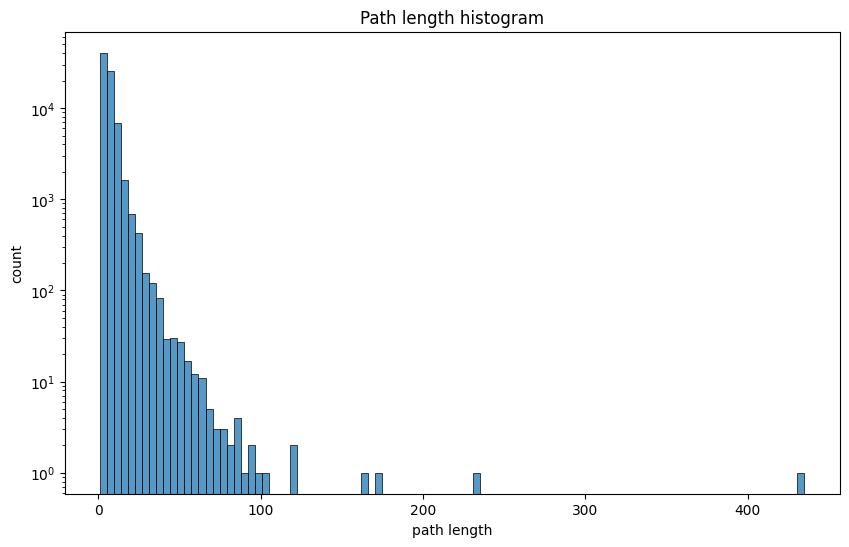

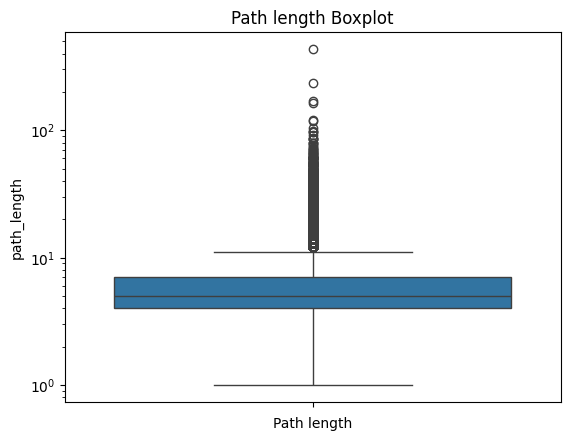

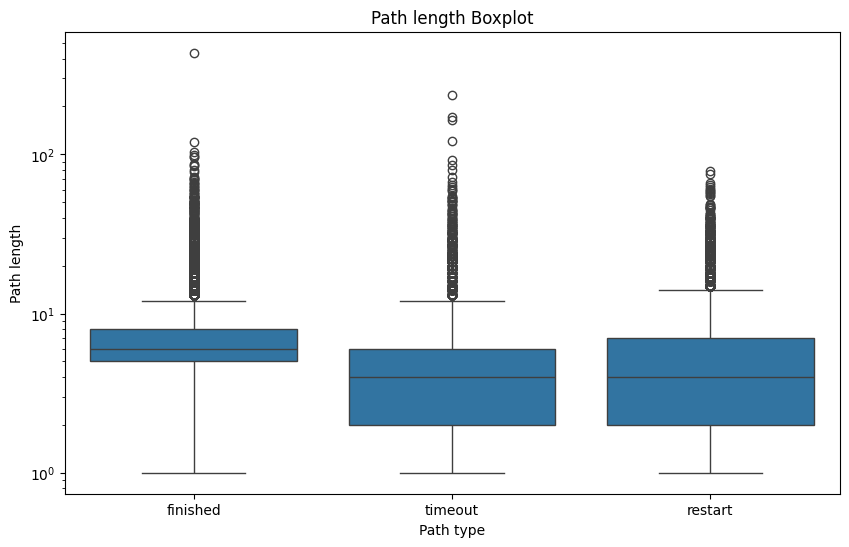

In [21]:
# plot the hist path length distribution and boxplot
plt.figure(figsize=(10, 6))
sns.histplot(df['path_length'], kde=False, bins=100)
plt.yscale('log')
plt.xlabel('path length')
plt.ylabel('count')
plt.title('Path length histogram')
plt.show()

sns.boxplot(df['path_length'])
plt.xlabel('Path length')
plt.title('Path length Boxplot')
plt.yscale('log')
plt.show()

# 2 boxplot with finished and unfinished paths
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='path_length', data=df)
plt.yscale('log')
plt.xlabel('Path type')
plt.ylabel('Path length')
plt.title('Path length Boxplot')
plt.show()

- relation between a frequently visited article it's degree
For this we first calculate the frequency of each article in the paths, then we comparing with the degree of each article and calculate the correlation. the < value is substituted with the previous previous article in the path.

In [22]:
def replace_lt_with_previous(article_path):
    path_elements = article_path.split(';')
    for i, element in enumerate(path_elements):
        if element == '<' and i > 1:
            path_elements[i] = path_elements[i-2]
    return ';'.join(path_elements)

df['path'] = df['path'].apply(replace_lt_with_previous)

# count the frequency of each article
article_freq = pd.DataFrame(df['path'].apply(lambda x: x.split(';')).explode().value_counts()).reset_index()
articles_cnt = pd.merge( articles, article_freq, left_on='article', right_on='path', how='left').fillna(0)
# drop path column
articles_cnt.drop('path', axis=1, inplace=True)
articles_cnt['count'].describe()

count     4604.000000
mean       103.404214
std        339.894277
min          0.000000
25%         15.000000
50%         34.000000
75%         81.000000
max      13617.000000
Name: count, dtype: float64

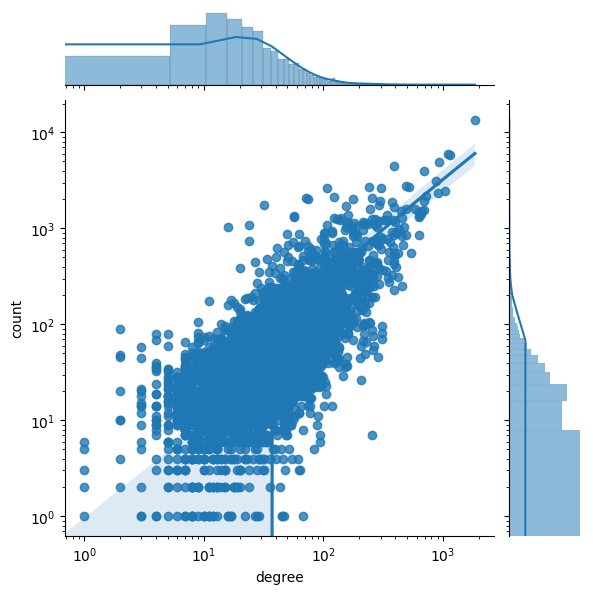

In [23]:
sns.jointplot(x='degree', y='count', data=articles_cnt, kind='reg')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [24]:
# test if the degree and count are correlated
from scipy.stats import pearsonr
pearsonr(articles_cnt['degree'], articles_cnt['count'])

PearsonRResult(statistic=0.765211321722257, pvalue=0.0)

It's obvious that the degree and count are highly correlated, which means that the higher degree it has, the more he frequent an article is visited in the game

- analysis of the the path length in the game and the theoretical shortest path length
we only consider the finished paths here because we don't know how long will it expected to be when the unfinished path is completed.
*it's noticed that there is one row in the game that the user can finish it by one click but the shortest path length is none according to the data, the reason of that has to be investigated later*

In [25]:
file_path = '../data/shortest-path-distance-matrix.txt'
df_shortest_path = pd.read_csv(file_path, sep='\t', header=None)


def find_p(row):
    start_idx = articles[articles['article'] == row['start']].index
    target_idx = articles[articles['article'] == row['target']].index
    if(row['type'] != 'finished'):
        return -1
    if not start_idx.empty and not target_idx.empty:

        start_idx = start_idx[0]
        target_idx = target_idx[0]

        s = df_shortest_path.iloc[start_idx][0]

        return 0 if s[target_idx] == '_' else int(s[target_idx])
    else:
        print(row['start'], row['target'],row['type'],row['path'])
        return 0

df['shortest_path'] = df.apply(find_p, axis=1)

PearsonRResult(statistic=0.20097957001845854, pvalue=0.0)

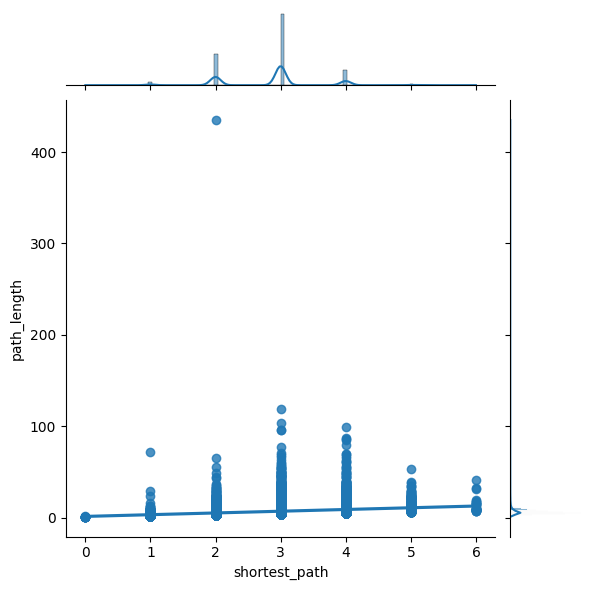

In [26]:
sns.jointplot(x='shortest_path', y='path_length', data=df[df['type'] == 'finished'], kind='reg')

pearsonr(df['shortest_path'], df['path_length'])